2025-05-05 08:31:09.327222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746433869.498482      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746433869.549499      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1746433903.762401      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Training RNN model...
Epoch 1/5


I0000 00:00:1746433907.026187      92 service.cc:148] XLA service 0x7ad390003b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746433907.026764      92 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746433907.449273      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/562 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.4810 - loss: 0.7002

I0000 00:00:1746433908.430820      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.7239 - loss: 0.4807 - val_accuracy: 0.7905 - val_loss: 0.3655
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.7883 - loss: 0.3725 - val_accuracy: 0.7693 - val_loss: 0.4064
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.7923 - loss: 0.3564 - val_accuracy: 0.7797 - val_loss: 0.3692
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.8103 - loss: 0.3200 - val_accuracy: 0.8174 - val_loss: 0.3723
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.8404 - loss: 0.3192 - val_accuracy: 0.8349 - val_loss: 0.3426

Training LSTM model...
Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.7899 - loss: 0.4184 - val_accuracy: 0.9386 - val_loss: 0.1791
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9301 - loss: 0.1948 - val_accuracy: 0.8865 - val_loss: 0.2738
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9378 - loss: 0.1

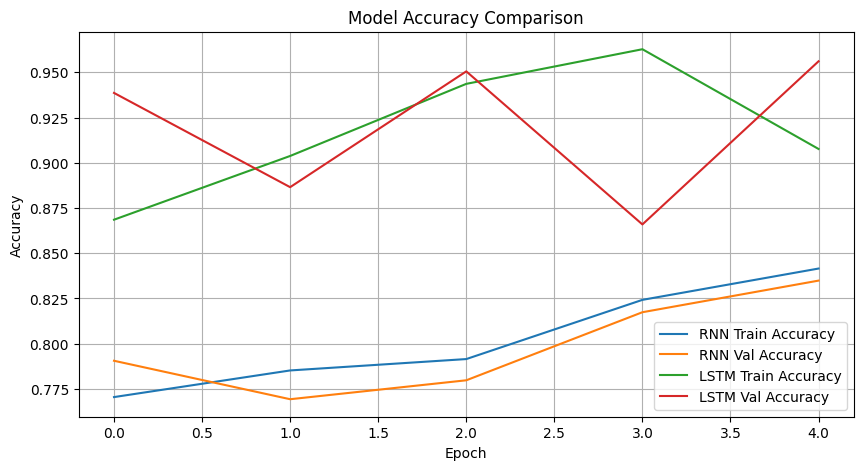

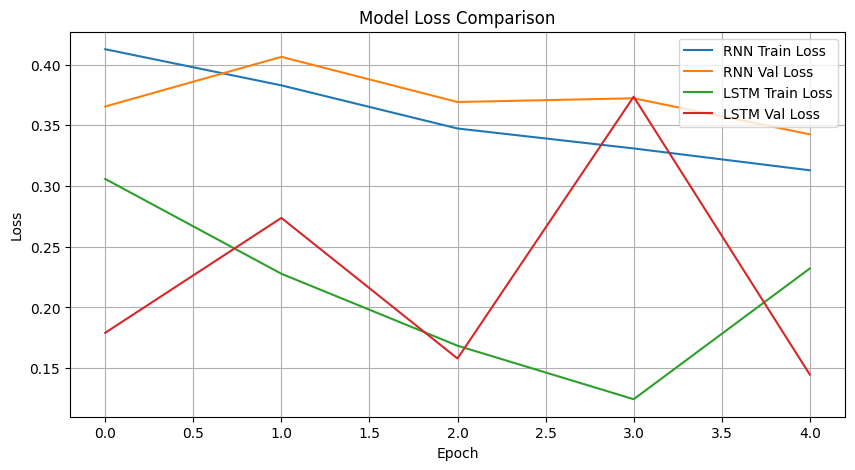

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from sklearn.model_selection import train_test_split
import re

# Load data
real = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
fake = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')

# Add labels
real['label'] = 0
fake['label'] = 1

# Select only 'text' and 'label'
real = real[['text', 'label']]
fake = fake[['text', 'label']]

# Merge datasets
data = pd.concat([real, fake], axis=0).reset_index(drop=True)

# Preprocessing function
def preprocess_text(text):
    text = text.lower()                          # Lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)       # Remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text)              # Remove extra spaces
    return text

data['text'] = data['text'].apply(preprocess_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42, stratify=data['label']
)

# Tokenization and Padding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 300  # you can tune this
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1

# Build RNN model
rnn_model = Sequential([
    Embedding(vocab_size, 64, input_length=max_len),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train RNN and save history
print("Training RNN model...")
rnn_history = rnn_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

# Build LSTM model
lstm_model = Sequential([
    Embedding(vocab_size, 64, input_length=max_len),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train LSTM and save history
print("\nTraining LSTM model...")
lstm_history = lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

# -----------------------------
# Plotting
# -----------------------------

# Accuracy plot
plt.figure(figsize=(10,5))
plt.plot(rnn_history.history['accuracy'], label='RNN Train Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Val Accuracy')
plt.plot(lstm_history.history['accuracy'], label='LSTM Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss plot
plt.figure(figsize=(10,5))
plt.plot(rnn_history.history['loss'], label='RNN Train Loss')
plt.plot(rnn_history.history['val_loss'], label='RNN Val Loss')
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


Training multi-layer RNN model...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


562/562 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - accuracy: 0.7053 - loss: 0.4961 - val_accuracy: 0.8086 - val_loss: 0.3050
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.8956 - loss: 0.2286 - val_accuracy: 0.9038 - val_loss: 0.2233
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.9490 - loss: 0.1454 - val_accuracy: 0.7910 - val_loss: 0.3432
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.8034 - loss: 0.3193 - val_accuracy: 0.7659 - val_loss: 0.4003
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.8199 - loss: 0.3135 - val_accuracy: 0.8761 - val_loss: 0.2954

Training multi-layer LSTM model...
Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.7570 - loss: 0.4406 - val_accuracy: 0.7411 - val_loss: 0.4793
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.9203 - loss: 0.2051 - val_accuracy: 0.9831 - val_loss: 0.0607
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.9854

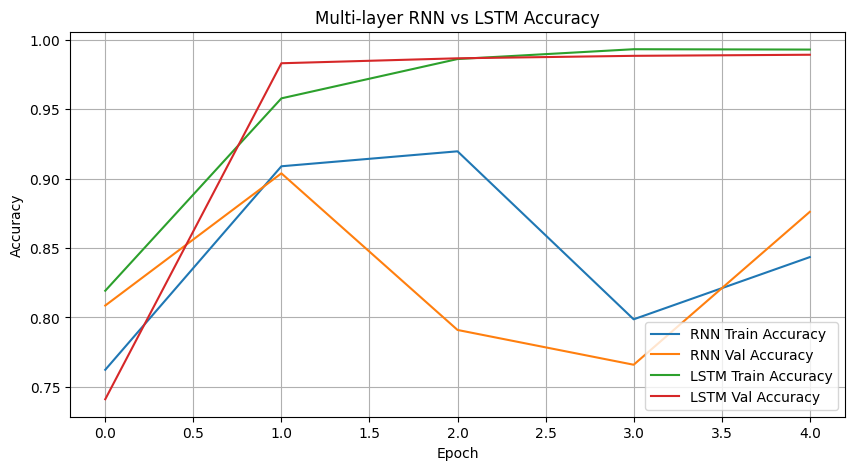

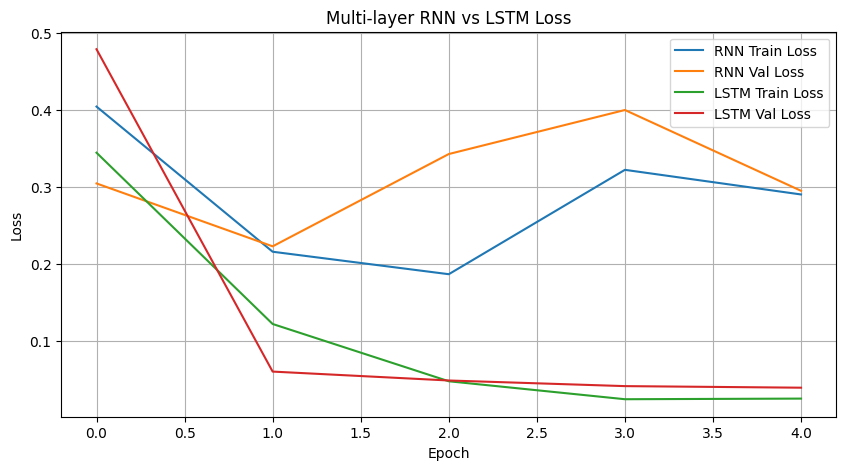

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from sklearn.model_selection import train_test_split
import re

# Load data
real = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
fake = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')

# Add labels
real['label'] = 0
fake['label'] = 1

# Select only 'text' and 'label'
real = real[['text', 'label']]
fake = fake[['text', 'label']]

# Merge datasets
data = pd.concat([real, fake], axis=0).reset_index(drop=True)

# Preprocessing function
def preprocess_text(text):
    text = text.lower()                          # Lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)       # Remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text)              # Remove extra spaces
    return text

data['text'] = data['text'].apply(preprocess_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42, stratify=data['label']
)

# Tokenization and Padding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 300  # you can tune this
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1

# -----------------------------
# Build multi-layered RNN model
# -----------------------------
rnn_model = Sequential([
    Embedding(vocab_size, 64, input_length=max_len),
    SimpleRNN(64, return_sequences=True),
    SimpleRNN(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train RNN and save history
print("Training multi-layer RNN model...")
rnn_history = rnn_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

# -----------------------------
# Build multi-layered LSTM model
# -----------------------------
lstm_model = Sequential([
    Embedding(vocab_size, 64, input_length=max_len),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train LSTM and save history
print("\nTraining multi-layer LSTM model...")
lstm_history = lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

# -----------------------------
# Plotting
# -----------------------------

# Accuracy plot
plt.figure(figsize=(10,5))
plt.plot(rnn_history.history['accuracy'], label='RNN Train Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Val Accuracy')
plt.plot(lstm_history.history['accuracy'], label='LSTM Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val Accuracy')
plt.title('Multi-layer RNN vs LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss plot
plt.figure(figsize=(10,5))
plt.plot(rnn_history.history['loss'], label='RNN Train Loss')
plt.plot(rnn_history.history['val_loss'], label='RNN Val Loss')
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss')
plt.title('Multi-layer RNN vs LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


2025-05-05 09:03:38.648130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746435818.836881      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746435818.892741      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1746435852.868481      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Training multi-layer RNN model...
Epoch 1/5


I0000 00:00:1746435857.697461      94 service.cc:148] XLA service 0x7fded4004740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746435857.697973      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746435858.208487      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/562 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - accuracy: 0.5391 - loss: 0.7010  

I0000 00:00:1746435859.556563      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


562/562 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.7159 - loss: 0.4823 - val_accuracy: 0.7815 - val_loss: 0.3826
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.7923 - loss: 0.3422 - val_accuracy: 0.7984 - val_loss: 0.3721
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.8324 - loss: 0.3299 - val_accuracy: 0.8236 - val_loss: 0.3639
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.8370 - loss: 0.3291 - val_accuracy: 0.8399 - val_loss: 0.3470
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.8310 - loss: 0.3182 - val_accuracy: 0.7998 - val_loss: 0.3462

Training multi-layer LSTM model...
Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.7510 - loss: 0.4258 - val_accuracy: 0.9634 - val_loss: 0.1273
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.9257 - loss: 0.1938 - val_accuracy: 0.9674 - val_loss: 0.1214
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.9036

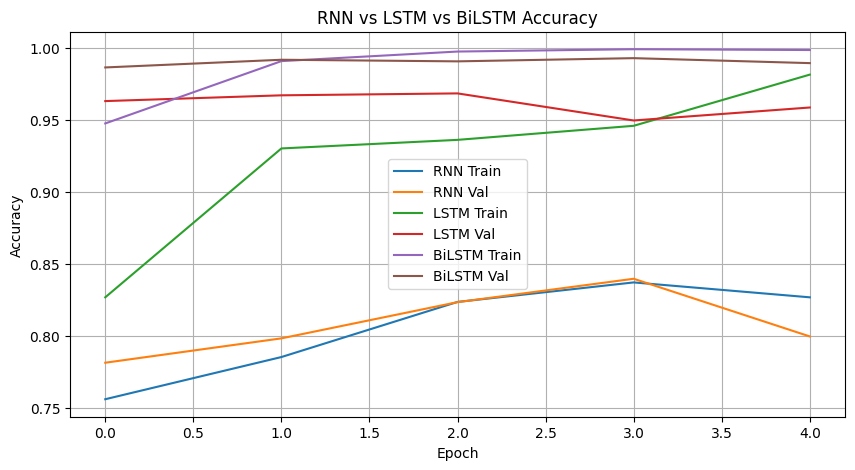

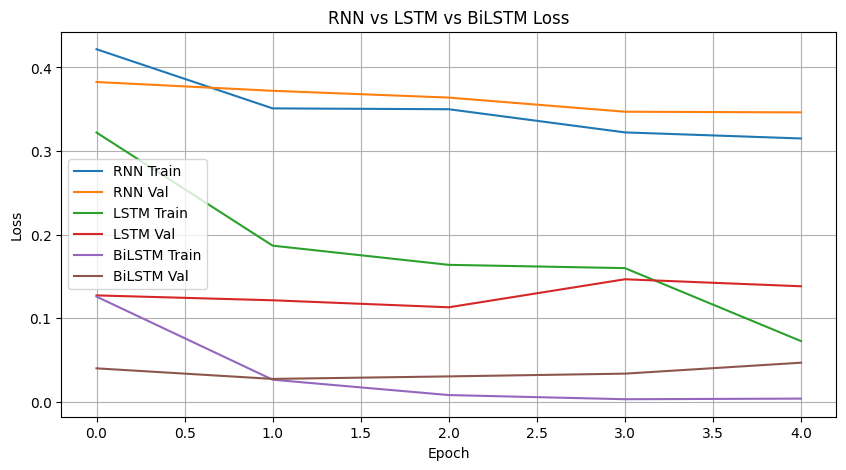

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Bidirectional
from sklearn.model_selection import train_test_split
import re

# Load data
real = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
fake = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')

# Add labels
real['label'] = 0
fake['label'] = 1

# Select only 'text' and 'label'
real = real[['text', 'label']]
fake = fake[['text', 'label']]

# Merge datasets
data = pd.concat([real, fake], axis=0).reset_index(drop=True)

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

data['text'] = data['text'].apply(preprocess_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42, stratify=data['label']
)

# Tokenization and Padding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 300
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1

# -----------------------------
# Build multi-layered RNN model
# -----------------------------
rnn_model = Sequential([
    Embedding(vocab_size, 64, input_length=max_len),
    SimpleRNN(64, return_sequences=True),
    SimpleRNN(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train RNN
print("Training multi-layer RNN model...")
rnn_history = rnn_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

# -----------------------------
# Build multi-layered LSTM model
# -----------------------------
lstm_model = Sequential([
    Embedding(vocab_size, 64, input_length=max_len),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train LSTM
print("\nTraining multi-layer LSTM model...")
lstm_history = lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

# -----------------------------
# Build Bidirectional LSTM model
# -----------------------------
bilstm_model = Sequential([
    Embedding(vocab_size, 64, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Bidirectional LSTM
print("\nTraining Bidirectional LSTM model...")
bilstm_history = bilstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

# -----------------------------
# Plotting Accuracy
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(rnn_history.history['accuracy'], label='RNN Train')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Val')
plt.plot(lstm_history.history['accuracy'], label='LSTM Train')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val')
plt.plot(bilstm_history.history['accuracy'], label='BiLSTM Train')
plt.plot(bilstm_history.history['val_accuracy'], label='BiLSTM Val')
plt.title('RNN vs LSTM vs BiLSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# -----------------------------
# Plotting Loss
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(rnn_history.history['loss'], label='RNN Train')
plt.plot(rnn_history.history['val_loss'], label='RNN Val')
plt.plot(lstm_history.history['loss'], label='LSTM Train')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val')
plt.plot(bilstm_history.history['loss'], label='BiLSTM Train')
plt.plot(bilstm_history.history['val_loss'], label='BiLSTM Val')
plt.title('RNN vs LSTM vs BiLSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from sklearn.model_selection import train_test_split
import re
import gc

# Load data
real = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
fake = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')

# Add labels
real['label'] = 0
fake['label'] = 1

# Select only 'text' and 'label'
real = real[['text', 'label']]
fake = fake[['text', 'label']]

# Merge datasets
data = pd.concat([real, fake], axis=0).reset_index(drop=True)

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

data['text'] = data['text'].apply(preprocess_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42, stratify=data['label']
)

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

# Different text lengths to try
max_lens = [30, 50, 100, 200, 300]

# Store results
rnn_val_acc = []
lstm_val_acc = []

for max_len in max_lens:
    print(f"\n----- Training with max_len = {max_len} -----")

    # Padding
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

    # Clear previous model
    tf.keras.backend.clear_session()

    # Build multi-layer RNN model
    rnn_model = Sequential([
        Embedding(vocab_size, 64, input_length=max_len),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(32),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print("Training RNN...")
    rnn_history = rnn_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test), verbose=0)
    
    rnn_val_acc.append(rnn_history.history['val_accuracy'][-1])  # Save last epoch val_acc

    # Clear previous model
    tf.keras.backend.clear_session()

    # Build multi-layer LSTM model
    lstm_model = Sequential([
        Embedding(vocab_size, 64, input_length=max_len),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print("Training LSTM...")
    lstm_history = lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test), verbose=0)
    
    lstm_val_acc.append(lstm_history.history['val_accuracy'][-1])  # Save last epoch val_acc

    # Free memory
    del rnn_model
    del lstm_model
    gc.collect()

# -----------------------------
# Plotting
# -----------------------------

plt.figure(figsize=(10,6))
plt.plot(max_lens, rnn_val_acc, marker='o', label='RNN Validation Accuracy')
plt.plot(max_lens, lstm_val_acc, marker='s', label='LSTM Validation Accuracy')
plt.title('Text Size (max_len) vs Validation Accuracy')
plt.xlabel('Text Size (max_len)')
plt.ylabel('Validation Accuracy')
plt.xticks(max_lens)
plt.grid()
plt.legend()
plt.show()
